In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
import seaborn as sns

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
import tensorflow.keras.layers as tfl

from sklearn.metrics import accuracy_score, classification_report, roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


tf.config.list_physical_devices()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Get the data

In [2]:
INPUT_PATH = '/kaggle/input/cat-and-dogs/dataset'
TRAIN_PATH = INPUT_PATH + '/training_set'
TEST_PATH = INPUT_PATH + '/test_set'

IMAGE_SIZE = (50,50,1)
BATCH_SIZE = 32

np.random.seed(123)

In [3]:
def extract(files):
    x = np.zeros(((len(files),)+IMAGE_SIZE[:2]))
    y = np.zeros((len(files)))
    
    for i, file in enumerate(files):
        img = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,tuple(IMAGE_SIZE[:2]),interpolation=cv2.INTER_AREA)
        img = img / 255.0
        x[i] = img
        
        y[i] = 0 if file.split('/')[-2] == 'cats' else 1
    
    return x[:,:,:,np.newaxis], y

In [4]:
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]
 
train_files = list_full_paths(TRAIN_PATH+'/cats')+list_full_paths(TRAIN_PATH+'/dogs')
test_files  = list_full_paths(TEST_PATH+'/cats')+list_full_paths(TEST_PATH+'/dogs')

x_train, y_train = extract(train_files)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 123, stratify = y_train)
x_test, y_test   = extract(test_files)

del train_files, test_files

In [5]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

(7200, 50, 50, 1) (7200,)
(800, 50, 50, 1) (800,)
(2000, 50, 50, 1) (2000,)


In [6]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0., 1.]), array([3600, 3600]))
(array([0., 1.]), array([400, 400]))
(array([0., 1.]), array([1000, 1000]))


# prepare the model

In [7]:
LEARNING_RATE = 0.0001

In [8]:
values = np.linspace(0.00001,LEARNING_RATE,20)[::-1]
boundaries = np.linspace(5, 100,19)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

In [9]:
model = keras.models.Sequential([
    tfl.Conv2D(
        32,
        3,
        activation = 'relu',
        input_shape = IMAGE_SIZE,
        padding='same'
    ),
    tfl.Dropout(0.5),
    tfl.Conv2D(
        64,
        3,
        activation = 'relu',
        padding='same'
    ),
    tfl.MaxPool2D(2,2),
        
#     tfl.BatchNormalization(),
    tfl.Flatten(),
    
    tfl.Dense(64, activation='relu',name='feature_extractor'),
    tfl.Dropout(0.3),

    tfl.Dense(1, activation='sigmoid')
], name = 'cat_dog_conv_net')

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

checkpoint_path = '/kaggle/working/checkpoints/cnn/'


Model: "cat_dog_conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
feature_extractor (Dense)    (None, 64)                2560064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)           

2023-01-12 16:48:21.400905: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
# del model

In [11]:
EPOCHS = 100

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

checkpoint = configure_checkpoints(checkpoint_path)

history = model.fit(
    x_train,
    y_train, 
    batch_size=BATCH_SIZE,
    validation_data = (x_val,y_val), 
    epochs = EPOCHS, 
    callbacks = [early_stopping,lr_scheduler,checkpoint],
)

2023-01-12 16:48:21.961806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0001, shape=(), dtype=float64).
225/225 [==============================] - 31s 133ms/step - loss: 0.6943 - accuracy: 0.5222 - val_loss: 0.6892 - val_accuracy: 0.5675
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0001, shape=(), dtype=float64).
225/225 [==============================] - 29s 131ms/step - loss: 0.6856 - accuracy: 0.5487 - val_loss: 0.6851 - val_accuracy: 0.5800
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0001, shape=(), dtype=float64).
225/225 [==============================] - 30s 131ms/step - loss: 0.6821 - accuracy: 0.5592 - val_loss: 0.6853 - val_accuracy: 0.5600
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0001, shape=(), dtype=float64).
225/225 [==============================] - 29s 131ms/step - loss: 0.6774 - accuracy: 0.5626 - val_loss: 0.6833 - val_accuracy: 0.5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0.5, 0, 'Epochs ')

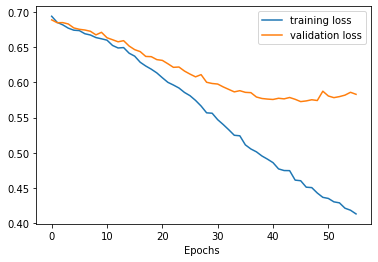

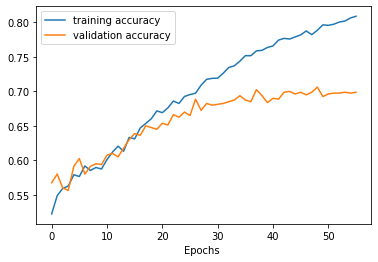

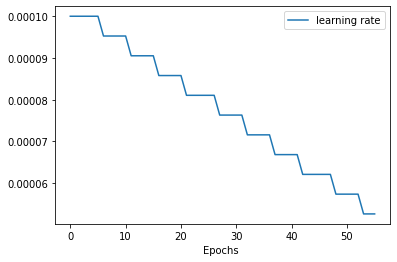

In [12]:
print(history.history.keys())
num=len(history.history['loss'])

plt.plot(range(num),history.history['loss'],label = 'training loss')
plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

plt.legend()

plt.xlabel("Epochs ")

plt.figure()

plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

plt.legend()
plt.xlabel("Epochs ")

plt.figure()

plt.plot(range(num),history.history['lr'],label = 'learning rate')

plt.legend()
plt.xlabel("Epochs ")

In [13]:
model.load_weights(checkpoint_path)

# Evaluate the model

63/63 [==============================] - 2s 31ms/step - loss: 0.5895 - accuracy: 0.7040
[0.5894639492034912, 0.7039999961853027]
              precision    recall  f1-score   support

         cat       0.70      0.70      0.70      1000
         dog       0.70      0.71      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



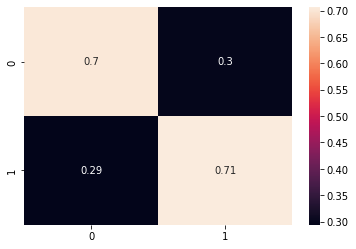

AUC = 0.7039999961853027


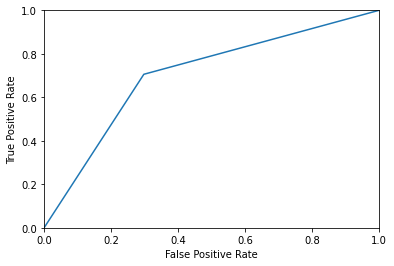

In [14]:
def eval_model(model,x,y,thresh=0.5):
    
    print(model.evaluate(x,y))
    y_pred = model.predict(x)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh ] = 0
    
    print(classification_report(y, y_pred, target_names=['cat','dog']))
    
    cm = tf.math.confusion_matrix(y,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.show()
    
    m = tf.keras.metrics.AUC(num_thresholds=80)
    m.update_state(y, y_pred)

    print(f'AUC = {m.result().numpy()}')

    fpr , tpr , thresholds = roc_curve ( y , y_pred)
    plt.figure()
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    
      
eval_model(model,x_test,y_test)

In [15]:
# feature extraction
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name='feature_extractor').output
)

features = feature_extractor.predict(x_train)
features.shape

(7200, 64)

In [16]:
features_test = feature_extractor.predict(x_test)
features_test.shape

(2000, 64)

In [17]:
clf = SVC()

In [18]:
clf.fit(X=features,y=y_train)

SVC()

In [19]:
y_pred = clf.predict(features_test)
accuracy_score(y_test,y_pred)

0.6995